Relevant tutorials:
- [scRNA-seq (scanpy)](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
- [multiome (muon)](https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/index.html)
- [CITE-seq (muon)](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html)

In [1]:
!pip install tables
!pip install muon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 4.7 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=37ab027d55ceb5793aa37d305b69a0134d80157d53bd6f77ac1f662958085fcd
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8048 sha256=d608ff37ce6fff905b5425e0b5e379090a73811ec93a1ebcddf9f14996ffe856
  Stored in di

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import mudata
from mudata import AnnData, MuData
import scanpy as sc
import muon as mu

In [3]:
DATA_DIR = Path("../input/open-problems-multimodal")

For demonstration purposes, only first 1000 cells will be loaded. For full data, free tier on Kaggle might not be enough.

In [4]:
N = 1000

# CITE-seq

1. Load CITE-seq data into AnnData/MuData format.
2. Run PCA/UMAP to visualize the data.

## anndata/mudata

In [5]:
rna_df = pd.read_hdf(DATA_DIR / "train_cite_inputs.h5", start=0, stop=N)
prot_df = pd.read_hdf(DATA_DIR / "train_cite_targets.h5", start=0, stop=N)

# # full data:
# rna_df = pd.read_hdf(DATA_DIR / "train_cite_inputs.h5")
# prot_df = pd.read_hdf(DATA_DIR / "train_cite_targets.h5")

In [6]:
rna = AnnData(csr_matrix(rna_df))
rna.obs_names = rna_df.index.values
rna.var_names = rna_df.columns.values

In [7]:
prot = AnnData(csr_matrix(prot_df))
prot.obs_names = prot_df.index.values
prot.var_names = prot_df.columns.values

In [8]:
cite = MuData({"rna": rna, "prot": prot})

In [9]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")
cite.obs = cite.obs.join(metadata.set_index("cell_id"))

cite.obs.donor = cite.obs.donor.astype("category")
cite.obs.cell_type = cite.obs.cell_type.astype("category")
cite.obs.day = cite.obs.day.astype("category")
cite.obs.technology = cite.obs.technology.astype("category")

In [10]:
with mudata.set_options(display_style="html", display_html_expand=0b100):
    display(cite)

MuData object with n_obs × n_vars = 1000 × 22190
  obs:	'day', 'donor', 'cell_type', 'technology'
  2 modalities
    rna:	1000 x 22050
    prot:	1000 x 140

## [rna] scanpy

### Feature selection

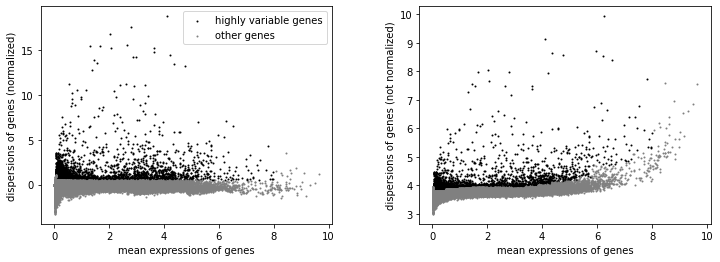

In [11]:
sc.pp.highly_variable_genes(rna, min_mean=0.05, max_mean=8, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

In [12]:
np.sum(rna.var.highly_variable)

2994

In [13]:
rna.layers["data"] = rna.X.copy()
sc.pp.scale(rna)

### PCA

In [14]:
sc.tl.pca(rna)

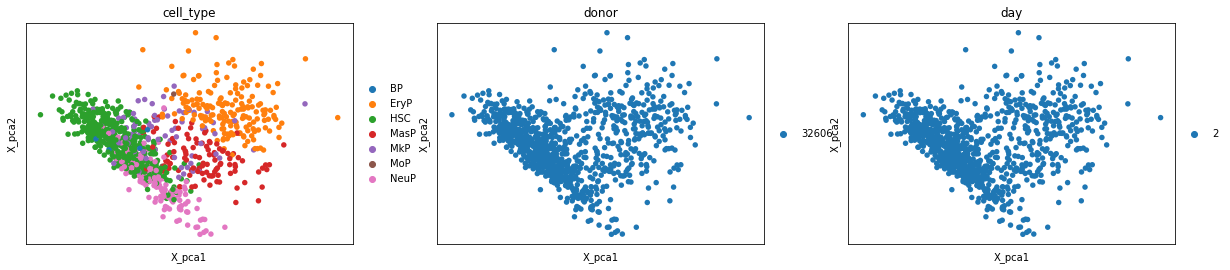

In [15]:
mu.pl.embedding(cite, basis="rna:X_pca", color=["cell_type", "donor", "day"])

### UMAP

In [16]:
sc.pp.neighbors(rna)
sc.tl.umap(rna, random_state=1)

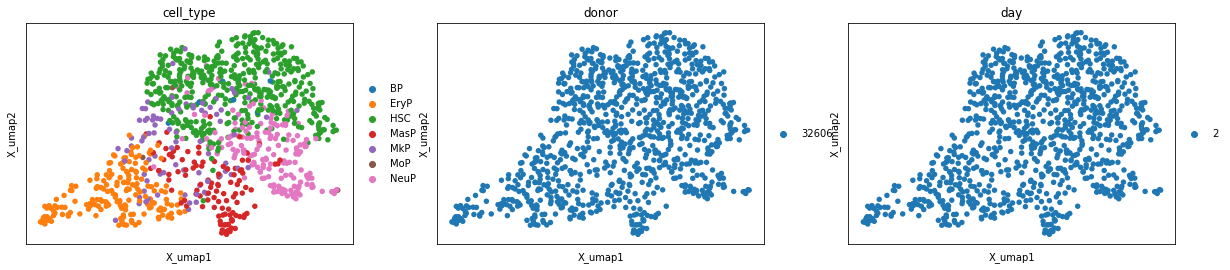

In [17]:
mu.pl.embedding(cite, basis="rna:X_umap", color=["cell_type", "donor", "day"])

## [prot] scanpy

In [18]:
prot.layers["data"] = prot.X.copy()
sc.pp.scale(prot)

### PCA

In [19]:
sc.tl.pca(prot)

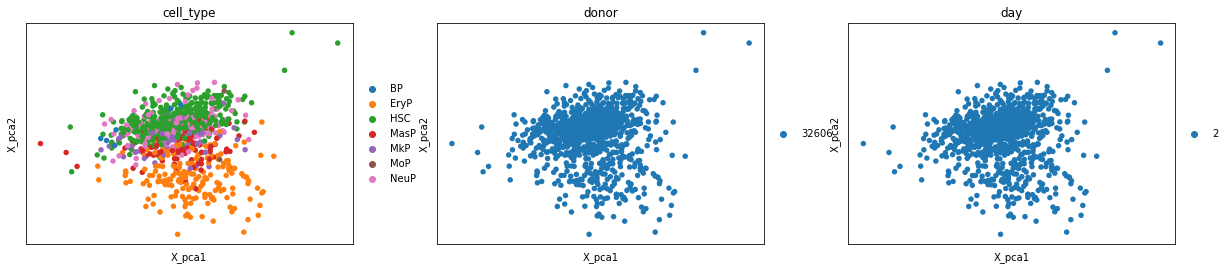

In [20]:
mu.pl.embedding(cite, basis="prot:X_pca", color=["cell_type", "donor", "day"])

In [21]:
sc.pp.neighbors(prot)

## [rna+atac] muon

In [22]:
cite.update()

In [23]:
cite
# cite.write("/kaggle/tmp/train_cite.h5mu")

MuData object with n_obs × n_vars = 1000 × 22190
  obs:	'day', 'donor', 'cell_type', 'technology'
  var:	'mean', 'std'
  2 modalities
    rna:	1000 x 22050
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'data'
      obsp:	'distances', 'connectivities'
    prot:	1000 x 140
      var:	'mean', 'std'
      uns:	'pca', 'neighbors'
      obsm:	'X_pca'
      varm:	'PCs'
      layers:	'data'
      obsp:	'distances', 'connectivities'

# Multiome

1. Load Multiome data into AnnData/MuData format.
2. Run PCA/UMAP to visualize the data.

## anndata/mudata

In [24]:
atac_df = pd.read_hdf(DATA_DIR / "train_multi_inputs.h5", start=0, stop=N)
rna_df = pd.read_hdf(DATA_DIR / "train_multi_targets.h5", start=0, stop=N)

# # full data:
# rna_df = pd.read_hdf(DATA_DIR / "train_multi_inputs.h5")
# prot_df = pd.read_hdf(DATA_DIR / "train_multi_targets.h5")

In [25]:
rna = AnnData(csr_matrix(rna_df))
rna.obs_names = rna_df.index.values
rna.var_names = rna_df.columns.values

In [26]:
atac = AnnData(csr_matrix(atac_df))
atac.obs_names = atac_df.index.values
atac.var_names = atac_df.columns.values

In [27]:
multiome = MuData({"rna": rna, "atac": atac})

In [28]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")
multiome.obs = multiome.obs.join(metadata.set_index("cell_id"))
multiome.obs.donor = multiome.obs.donor.astype("category")
multiome.obs.cell_type = multiome.obs.cell_type.astype("category")
multiome.obs.day = multiome.obs.day.astype("category")
multiome.obs.technology = multiome.obs.technology.astype("category")

In [29]:
with mudata.set_options(display_style="html", display_html_expand=0b100):
    display(multiome)

MuData object with n_obs × n_vars = 1000 × 252360
  obs:	'day', 'donor', 'cell_type', 'technology'
  2 modalities
    rna:	1000 x 23418
    atac:	1000 x 228942

## [rna] scanpy

### Feature selection

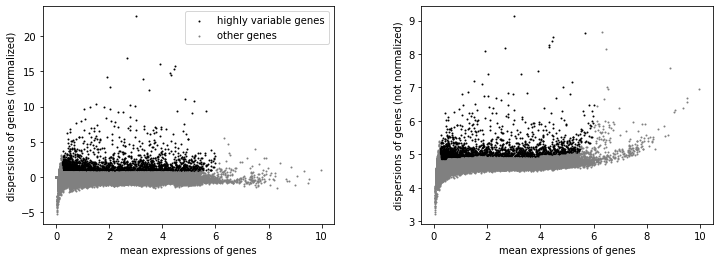

In [30]:
sc.pp.highly_variable_genes(rna, min_mean=0.2, max_mean=6, min_disp=0.8)
sc.pl.highly_variable_genes(rna)

In [31]:
np.sum(rna.var.highly_variable)

2276

In [32]:
rna.layers["data"] = rna.X.copy()
sc.pp.scale(rna)

### PCA

In [33]:
sc.tl.pca(rna)

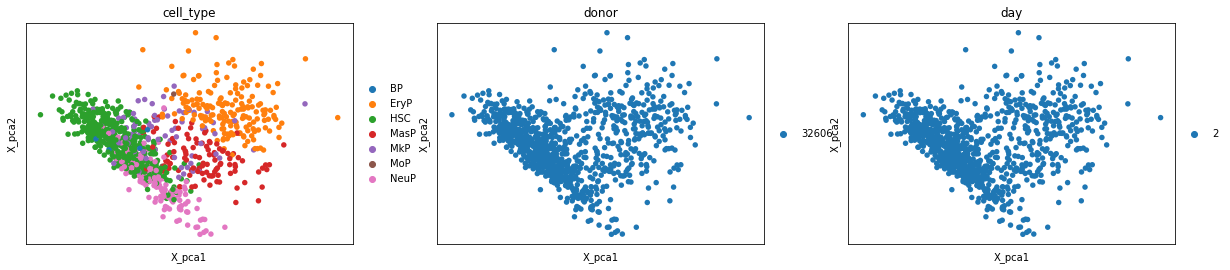

In [34]:
mu.pl.embedding(cite, basis="rna:X_pca", color=["cell_type", "donor", "day"])

### UMAP

In [35]:
sc.pp.neighbors(rna)
sc.tl.umap(rna, random_state=1)

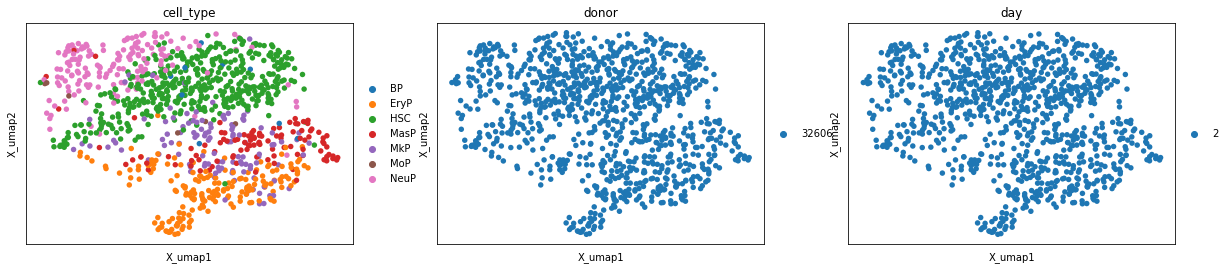

In [36]:
mu.pl.embedding(multiome, basis="rna:X_umap", color=["cell_type", "donor", "day"])

## [atac] scanpy

### Feature selection

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


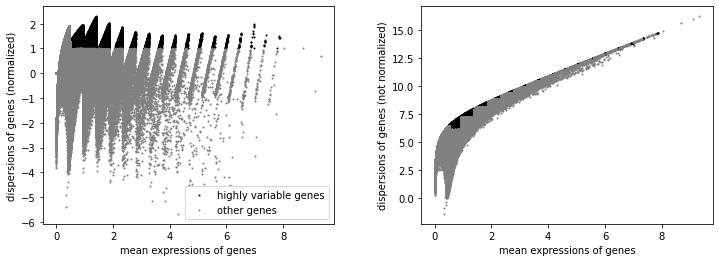

In [37]:
sc.pp.highly_variable_genes(atac, min_mean=0.5, max_mean=8, min_disp=1.0)
sc.pl.highly_variable_genes(atac)

In [38]:
np.sum(atac.var.highly_variable)

22104

### PCA

In [39]:
mu.atac.tl.lsi(atac)

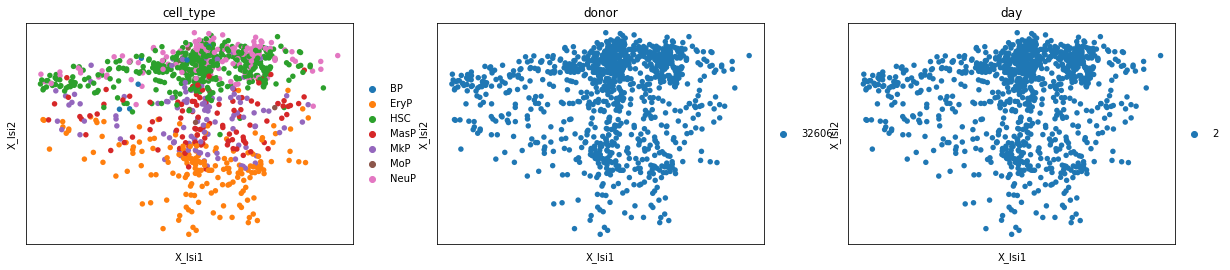

In [40]:
mu.pl.embedding(multiome, basis="atac:X_lsi", color=["cell_type", "donor", "day"])

### UMAP

In [41]:
sc.pp.neighbors(atac, use_rep="X_lsi")
sc.tl.umap(atac, random_state=1)

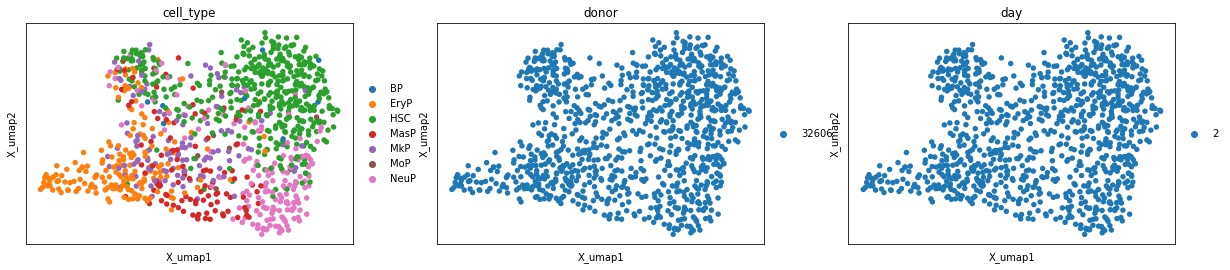

In [42]:
mu.pl.embedding(multiome, basis="atac:X_umap", color=["cell_type", "donor", "day"])

## [rna+atac] muon

In [43]:
multiome.update()

In [44]:
multiome
# multiome.write("/kaggle/tmp/train_multiome.h5mu")

MuData object with n_obs × n_vars = 1000 × 252360
  obs:	'day', 'donor', 'cell_type', 'technology'
  var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	1000 x 23418
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
      uns:	'hvg', 'pca', 'neighbors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'data'
      obsp:	'distances', 'connectivities'
    atac:	1000 x 228942
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'lsi', 'neighbors', 'umap'
      obsm:	'X_lsi', 'X_umap'
      varm:	'LSI'
      obsp:	'distances', 'connectivities'